# Evaluación de los algoritmos antes y después de aplicar PCA

## Imports y configuraciones

In [18]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
sys.path.append('../../../lab3/ej7/src') # permite importar modulos de otros directorios

In [21]:
from ds_preprocessing import DataSetPreprocessor
from arff_helper import DataSet
from classifier import KNNClassifier, NBClassifier
from kfold import KFold

## Carga/preprocesamiento de datasets

### Carga/preprocesamiento del dataset original (```ds```) 

In [22]:
ds = DataSet()
ds.load_from_arff('../../../lab2/ej5/datasets/Autism-Adult-Data.arff')
ds.remove_attribute('result')

Observando más en detalle nuestro algoritmo de PCA, vimos que para las filas número 62 y número 91 de ```row_data_adjust```, luego del segundo paso un atributo vale ```nan``` provocando que al multiplicar las matrices ```row_feature_vector``` y ```row_data_adjust``` los datos correspondientes a esas persona queden todos en ```nan```. A su vez, esto se corroboró en el dataset original en formato arff, en donde para esas personas el atributo ```age``` no está definido. Por lo tanto, **decidimos simplemente borrarlas para que todos los datasets concuerden en la cantidad de filas**: <a id='link-1'></a>

In [23]:
ds.pandas_df = ds.pandas_df.drop([62, 91])\
    .reset_index()\
    .drop(columns=['index'])

Separamos la columna con el atributo objetivo y la guardamos en ```y```:

In [24]:
target_attribute = 'Class/ASD'
y = ds.pandas_df[target_attribute]

### Transformación a atributos numéricos (```df_numeric```)

In [25]:
preprocessor = DataSetPreprocessor(ds, target_attribute)
df_numeric = preprocessor.transform_to_rn()\
    .drop(columns=target_attribute)

### Carga/preprocesamiento del dataset reducido a 96 dimensiones (```df_96```) 

Condición utilizada para selección de valores propios (parámetro ```eigenvalues_condition``` de la función ```pca``` del módulo ```pca.py```): 

$\lambda_i$ con $\lambda_i > 1x10^{-4}$ (todos menos los valores con exponente -17)

In [26]:
df_96 = pd.read_csv('../datasets/Autism-Adult-Data-96dim.csv')

Chequeamos las dimensiones :

In [27]:
print('Filas del dataset original : {}'.format(ds.pandas_df.shape[0]))
print('Filas del dataset reducido : {}'.format(df_96.shape[0]))
print('Columnas del dataset reducido : {}'.format(df_96.shape[1]))

Filas del dataset original : 702
Filas del dataset reducido : 702
Columnas del dataset reducido : 96


(recordar que fueron quitadas dos filas del dataset original)

### Carga/preprocesamiento del dataset reducido a 67 dimensiones (```df_67```) 

Condición utilizada para selección de valores propios : $\lambda_i$ con $\lambda_i > 2x10^{-3}$ 

In [28]:
df_67 = pd.read_csv('../datasets/Autism-Adult-Data-67dim.csv')

Chequeamos las dimensiones :

In [29]:
print('Filas del dataset original : {}'.format(ds.pandas_df.shape[0]))
print('Filas del dataset reducido : {}'.format(df_67.shape[0]))
print('Columnas del dataset reducido : {}'.format(df_67.shape[1]))

Filas del dataset original : 702
Filas del dataset reducido : 702
Columnas del dataset reducido : 67


### Carga/preprocesamiento del dataset reducido a 39 dimensiones (```df_39```) 

Condición utilizada para selección de valores propios : $\lambda_i$ con $\lambda_i > 1x10^{-2}$ 

In [30]:
df_39 = pd.read_csv('../datasets/Autism-Adult-Data-39dim.csv')

Chequeamos las dimensiones :

In [31]:
print('Filas del dataset original : {}'.format(ds.pandas_df.shape[0]))
print('Filas del dataset reducido : {}'.format(df_39.shape[0]))
print('Columnas del dataset reducido : {}'.format(df_39.shape[1]))

Filas del dataset original : 702
Filas del dataset reducido : 702
Columnas del dataset reducido : 39


## Evaluación de los algoritmos

Todas las evaluaciones que siguen fueron hechas mediante cross-validation con 10 folds (k=10). Se realizan las particiones sobre el dataset original (```df_numeric```) **completo**. En cada una de las 10 iteraciones se toman los índices de las instancias de test y training a partir del dataset original y se obtienen **las mismas instancias de test y training** pero de los siguientes datasets :

- ```df_numeric```
- ```df_96```
- ```df_67``` 
- ```df_39```

Recordar que las instancias en los datasets reducidos son las mismas que en el dataset original o dicho de otro modo, la cantidad de filas es la misma.

### Evaluación de K Nearest Neighbours

In [32]:
def eval_knn(datasets, y, metric_fn):

    r = [[] for _ in range(len(datasets))]
    clf = clf = KNNClassifier(3)
    kf = KFold(n_splits=10, do_shuffle=False)
    indexes = kf.split(datasets[0])
    
    for test_indexes, training_indexes in indexes:
        
        for (i, X) in enumerate(datasets):

            y_test = y.iloc[test_indexes]
            X_test = X.iloc[test_indexes]

            y_train = y.iloc[training_indexes]
            X_train = X.iloc[training_indexes]

            clf.fit(X_train, y_train)
            y_predicted = clf.predict(X_test)
            r[i].append(metric_fn(y_test, y_predicted))
        
        print('[' + '>'*len(r[0]) + ' '*(10-len(r[0])) + ']', end='\r')

    return r

#### Evaluación de accuracy

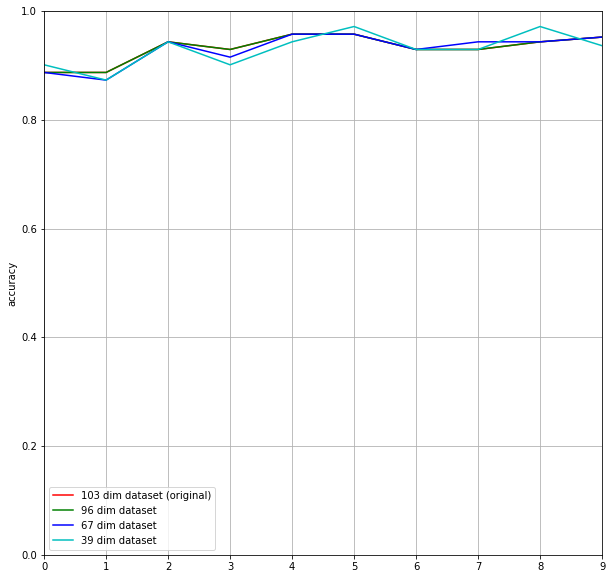

In [33]:
datasets = [df_numeric, df_96, df_67, df_39]
r = eval_knn(datasets, y, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('accuracy')
plt.axis([0, 9, 0, 1])
plt.grid(True)
plt.plot(r[0], color='r', label='103 dim dataset (original)')
plt.plot(r[1], color='g', label='96 dim dataset')
plt.plot(r[2], color='b', label='67 dim dataset')
plt.plot(r[3], color='c', label='39 dim dataset')
plt.legend(loc=0)
plt.show()

### Evaluación de Naive Bayes

In [34]:
def create_nb_classifier(target_attribute, X, y):
    
    attribute_info = {}
    attribute_list = []
    
    for c in X.columns.values:
        attribute_info[c] = DataSet.AttributeInfo(c, float)
        attribute_list.append(c)
    
    return NBClassifier(target_attribute, attribute_info, attribute_list)


def eval_nb(original_dataset, reduced_dataframes, y, metric_fn):

    r = [[] for _ in range(len(reduced_dataframes) + 1)]
    kf = KFold(n_splits=10, do_shuffle=False)
    indexes = kf.split(original_dataset.pandas_df)
    
    for test_indexes, training_indexes in indexes:
        
        clf = NBClassifier(target_attribute, ds.attribute_info, ds.attribute_list)
        
        y_test = y.iloc[test_indexes]
        X_test = ds.pandas_df.iloc[test_indexes]
        
        y_train = y.iloc[training_indexes]
        X_train = ds.pandas_df.iloc[training_indexes]
        
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)
        r[0].append(metric_fn(y_test, y_predicted))
        
        for (i, X) in enumerate(reduced_dataframes):
            
            clf = create_nb_classifier(target_attribute, X, y)

            y_test = y.iloc[test_indexes]
            X_test = X.iloc[test_indexes]

            y_train = y.iloc[training_indexes]
            X_train = X.iloc[training_indexes]

            clf.fit(X_train, y_train)
            y_predicted = clf.predict(X_test)
            r[i+1].append(metric_fn(y_test, y_predicted))
        
        print('[' + '>'*len(r[0]) + ' '*(10-len(r[0])) + ']', end='\r')

    return r

#### Evaluación de accuracy

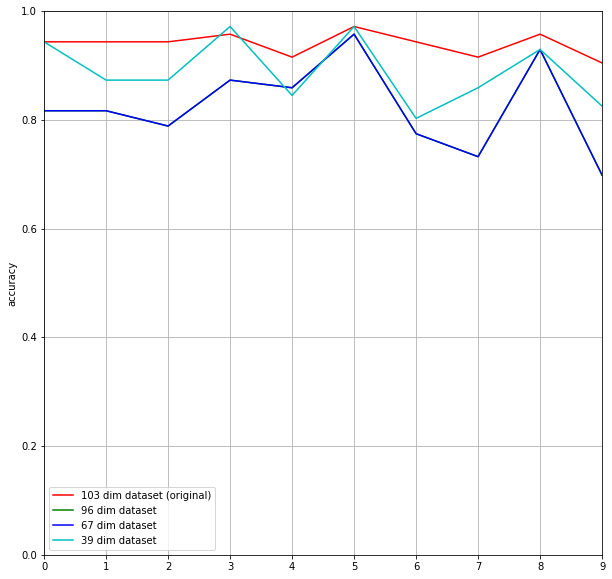

In [35]:
reduced_dataframes = [df_96, df_67, df_39]
original_dataset = ds
r = eval_nb(original_dataset, reduced_dataframes, y, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('accuracy')
plt.axis([0, 9, 0, 1])
plt.grid(True)
plt.plot(r[0], color='r', label='103 dim dataset (original)')
plt.plot(r[1], color='g', label='96 dim dataset')
plt.plot(r[1], color='b', label='67 dim dataset')
plt.plot(r[3], color='c', label='39 dim dataset')
plt.legend(loc=0)
plt.show()